In [1]:
from __future__ import print_function

import pyKriging
from pyKriging.krige import kriging
from pyKriging.samplingplan import samplingplan

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import pylab

from nltrans import Transformation
#######################################################
from zimg import SimImg
from zimg import AutoFocus

import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import filters
import cv2

def normalize_img(img):
    img = img / np.max(img) * (2 ** 8 - 1)
    img = np.clip(img, 0, 2 ** 8 - 1)
    img = img.astype('uint8')
    return img


def find_circle(img):
    img_size = 512
    circles = cv2.HoughCircles(filters.gaussian_filter(img, (15, 15)), method=cv2.HOUGH_GRADIENT, dp=1,
                               minDist=img_size, minRadius=1, maxRadius=img_size, param1=0.001, param2=0.001)
    circle = circles[0, 0, :]
    return circle


def rms(data1, data2):
    return ((np.asarray(data1) - np.asarray(data2)) ** 2).mean() ** .5
#######################################################

In [10]:
# generate points from different coord systems (trans1.applytrans)
number_of_point = 4
size_of_img = 500
noise_percentage = 0
noise = (np.random.rand(number_of_point* number_of_point,2) - 0.5) * (size_of_img * noise_percentage)

points_1 = np.linspace(size_of_img * 0.1, size_of_img * 0.9, num=number_of_point)
points_1 = np.meshgrid(points_1, points_1)
points_1 = np.reshape(np.ravel(points_1), (2, number_of_point ** 2)).T

# trans1 = Transformation('linear', points_1)
# ideal_trans = [[1.2, -0.1, -100], [0, 1, -100]]

trans1 = Transformation('nonlinear', points_1)
ideal_trans = [[0.707, -0.5, 0, 250], [0.5, 0.707, 0, 250]]
print('ideal_trans: '+str(ideal_trans))

points_2_ideal = trans1.applytrans(ideal_trans)
points_2_with_noise_sim_2D = points_2_ideal + noise
trans1.data2=points_2_with_noise_sim_2D
############################################################
# simulate images and get x,y,z (autofocus and find center)
# #2D: z = 0
z=np.ones((points_2_with_noise_sim_2D.shape[0], 1))
# #3D: z = (x+y)/100
# z=np.vstack(((points_2_with_noise_sim_2D[:,0]+points_2_with_noise_sim_2D[:,1])/50-10))
points_2_with_noise_sim_3D=np.hstack((points_2_with_noise_sim_2D,z))                        
points_2_fitting = []
for (x2_sim,y2_sim,z2_sim) in points_2_with_noise_sim_3D:
    point_2=SimImg(int(np.max(points_2_with_noise_sim_3D))+1,x2_sim,y2_sim,z2_sim) 
    getfocus_pt2=AutoFocus(point_2.sim_z, -10,10)
    # find z (focus)
    z_temp=getfocus_pt2.quad_fitting_focus(4)
    # find x,y (position)
    (x_temp,y_temp)=getfocus_pt2.find_circle(z_temp)[0:2]
    points_2_fitting.append([x_temp,y_temp,z_temp])
    
points_2_fitting=np.array(points_2_fitting)
print('points_2_with_noise_sim: \n'+str(points_2_with_noise_sim_3D))
print('\npoints_2_fitting: \n'+str(np.array(points_2_fitting)))
print('\nerror: \n'+ str(points_2_with_noise_sim_3D-np.array(points_2_fitting)))
############################################################


ideal_trans: [[0.707, -0.5, 0, 250], [0.5, 0.707, 0, 250]]
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.4346257436680383
find_circ, z: -10
find_circ, z: 10
find_circ, z: 0.0
find_circ, z: 1.4299418745554708
find_circ, z: 1.434625

[0.01, 0.01, 2, 2]
[0.1, 0.1, 2, 2]
Now plotting final results of k1...


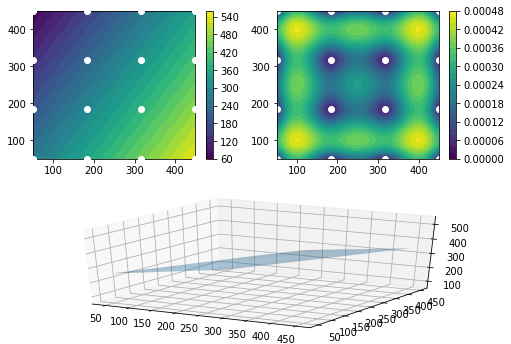

[0.01, 0.01, 2, 2]
[0.1, 0.1, 2, 2]
Now plotting final results of k2...


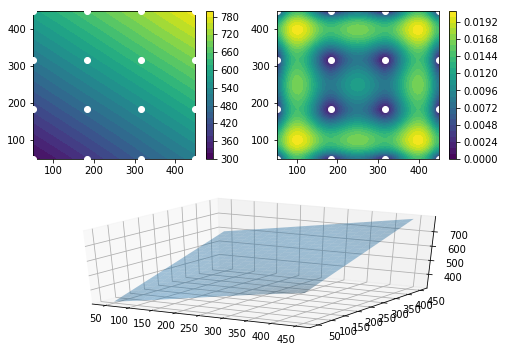

[0.01, 0.01, 2, 2]
[0.1, 0.1, 2, 2]
Now plotting final results of k3...


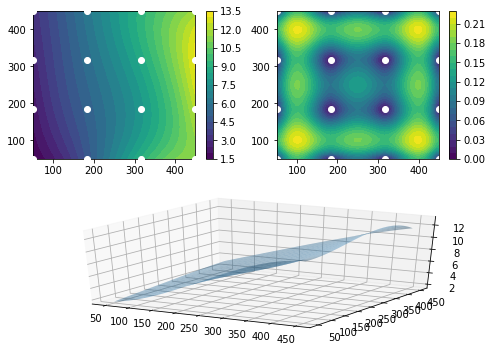

In [3]:
thetamin = 1e-2
thetamax = 1e-1

# kriging
k1 = kriging(points_1, points_2_fitting[:, 0], name='simple', testPoints=25)
k1.thetamin = thetamin
k1.thetamax = thetamax
k1.train(optimizer='ga')
k1.snapshot()
print('Now plotting final results of k1...')
X, Y, kx = k1.plot()
######
k2 = kriging(points_1, points_2_fitting[:, 1], name='simple', testPoints=25)
k2.thetamin = thetamin
k2.thetamax = thetamax
k2.train(optimizer='ga')
k2.snapshot()
print('Now plotting final results of k2...')
X, Y, ky = k2.plot()
######
# thetamin = 1e-2
# thetamax = 1e-1

k3 = kriging(points_1, points_2_fitting[:, 2], name='simple', testPoints=25)
k3.thetamin = thetamin
k3.thetamax = thetamax
k3.train(optimizer='ga')
k3.snapshot()
print('Now plotting final results of k3...')
X, Y, kz = k3.plot()
############################################################

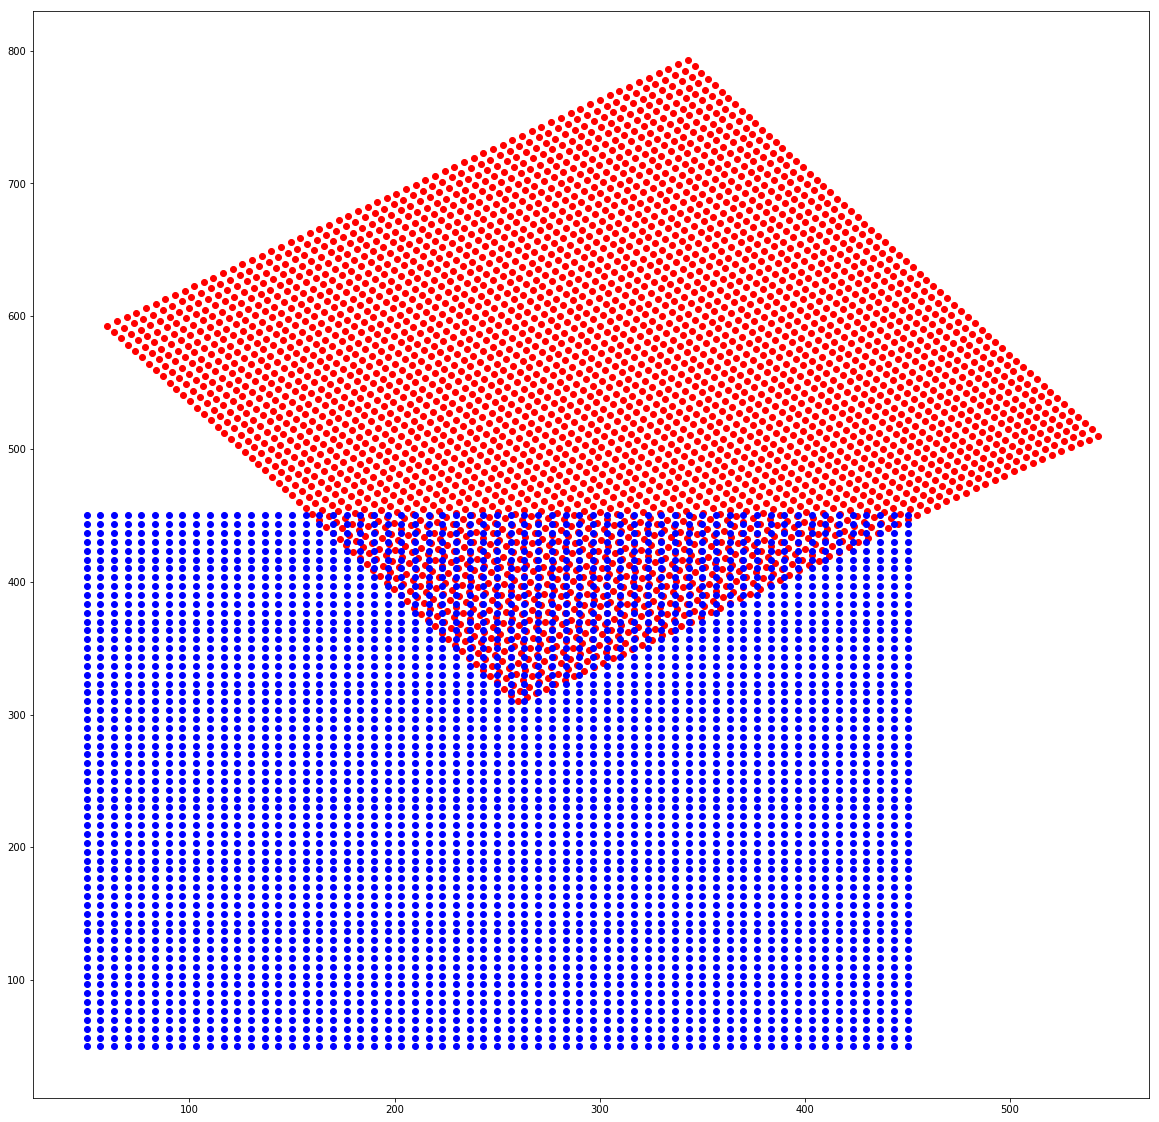

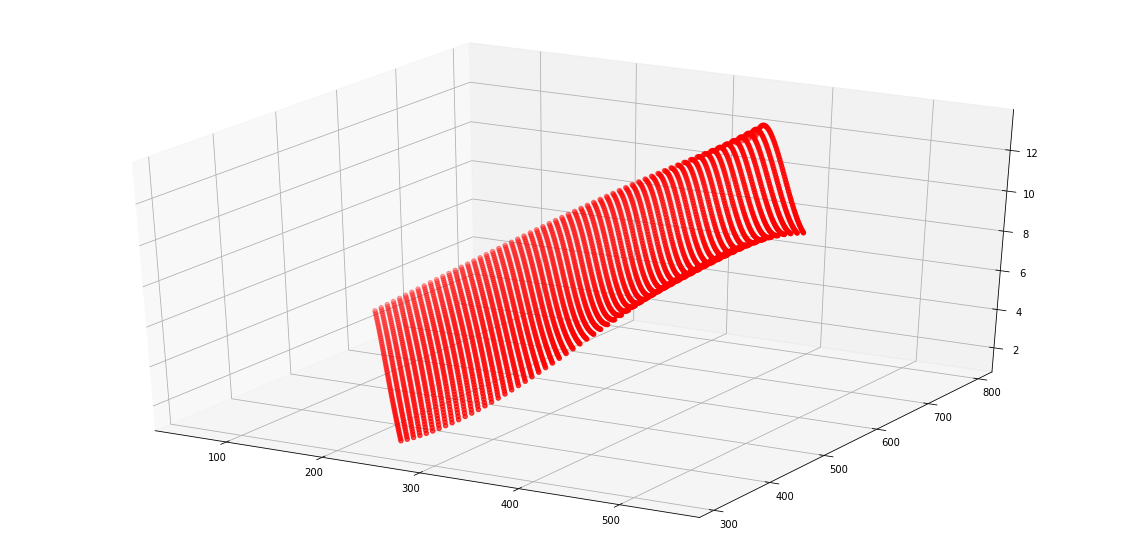

In [4]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.scatter(kx, ky,c='r')
ax.scatter(X, Y,c='b')
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kx, ky, kz,c='r')
plt.show()

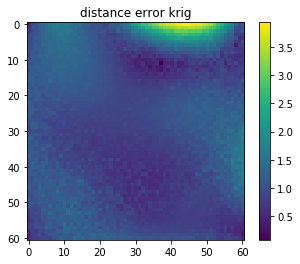

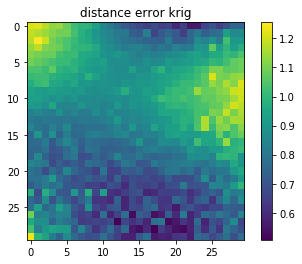

In [8]:
####################################
# apply transform with [61,61] points to 3 different methods
# then show the rms as image

XY = np.dstack((X, Y))
XY = np.reshape(XY, (-1, 2))

krigXY = np.dstack((kx, ky,kz))
krigXY = np.reshape(krigXY, (-1, 3))

idealXY = trans1.applytrans(ideal_trans,XY)
z=np.vstack(((idealXY[:,0]+idealXY[:,1])/50-10))
idealXY=np.hstack((idealXY,z))    

rms_krig = np.array(((krigXY[:, 0] - idealXY[:, 0]) ** 2 + (krigXY[:, 1] - idealXY[:, 1]) ** 2 + (krigXY[:, 2] - idealXY[:, 2]) ** 2) ** 0.5)
rms_krig = np.reshape(rms_krig, (61, 61))

fig = pylab.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.imshow(rms_krig)
plt.title('distance error krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()

fig.add_subplot(122)
plt.imshow(rms_krig[15:45,15:45])
plt.title('distance error krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()


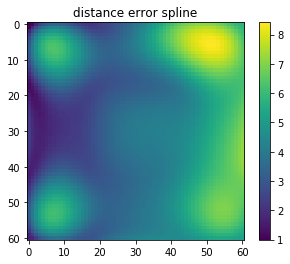

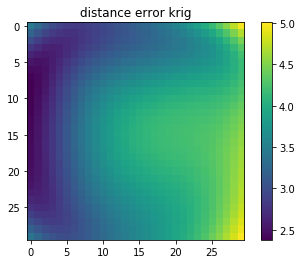

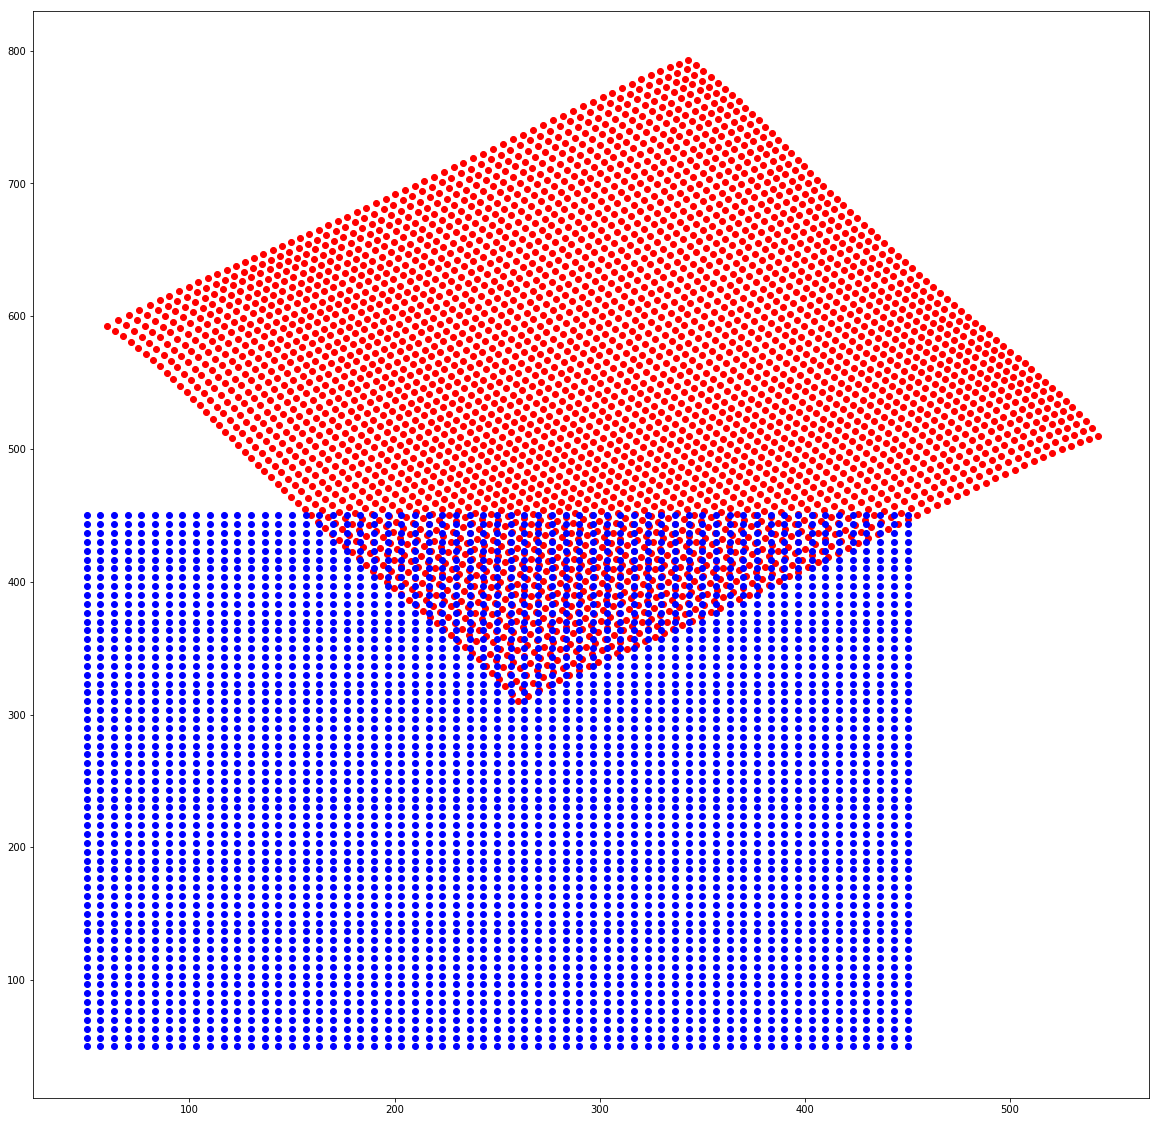

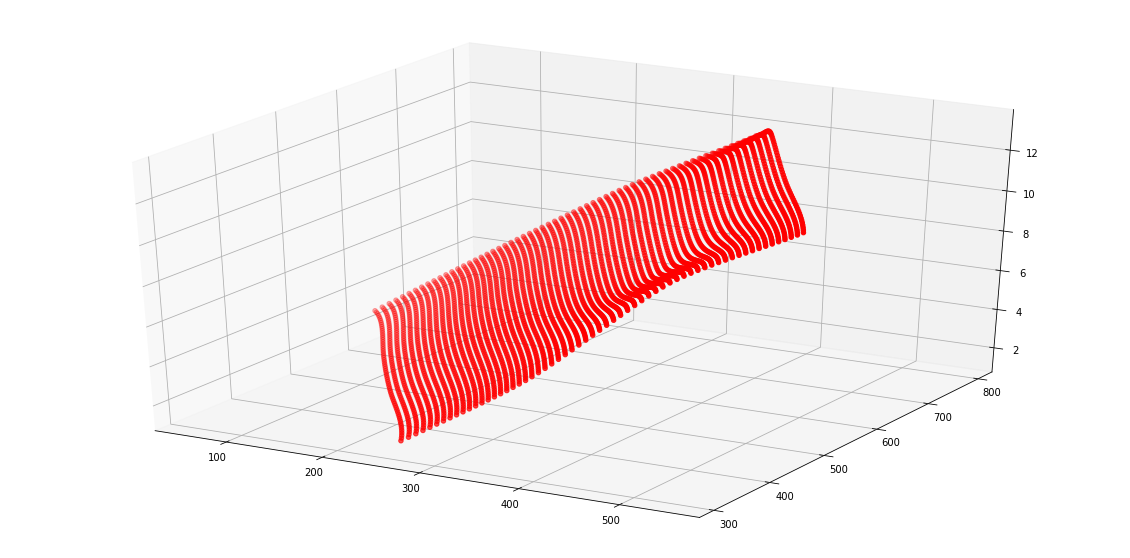

In [6]:
# test spline
# https://stackoverflow.com/questions/46040382/spline-interpolation-in-3d-in-python
import scipy as sp
fn='thin_plate'
ep=None
spline_x = sp.interpolate.Rbf(points_1[:, 0],points_1[:, 1], points_2_fitting[:, 0],function=fn,smooth=5, episilon=ep)
spline_y = sp.interpolate.Rbf(points_1[:, 0],points_1[:, 1], points_2_fitting[:, 1],function=fn,smooth=5, episilon=ep)
spline_z = sp.interpolate.Rbf(points_1[:, 0],points_1[:, 1], points_2_fitting[:, 2],function=fn,smooth=5, episilon=ep)

sx=spline_x(X,Y)
sy=spline_y(X,Y)
sz=spline_z(X,Y)

splineXY = np.dstack((sx, sy,sz))
splineXY = np.reshape(splineXY, (-1, 3))

dist_spline = np.array(((splineXY[:, 0] - idealXY[:, 0]) ** 2 + (splineXY[:, 1] - idealXY[:, 1]) ** 2 + (splineXY[:, 2] - idealXY[:, 2]) ** 2) ** 0.5)
dist_spline = np.reshape(dist_spline, (61, 61))

fig = pylab.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.imshow(dist_spline)
plt.title('distance error spline')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()

fig.add_subplot(122)
plt.imshow(dist_spline[15:45,15:45])
plt.title('distance error krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.scatter(sx, sy,c='r')
ax.scatter(X, Y,c='b')
plt.show()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sx, sy,sz,c='r')
plt.show()